<a href="https://colab.research.google.com/github/jasreman8/Single-Agent-Systems-II/blob/main/Agentic_Expense_Claim_Automation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><p float="center">
  <img src="https://mma.prnewswire.com/media/1458111/Great_Learning_Logo.jpg?p=facebook" width="200" height="100"/>
</p></center>                                                                         <center><h1></h1></center>
<h1><left> <font size=5>MLS 7: Single-Agent Systems</font></left></h1>

# Business Context

## Automated Expense Claim Processing Using Agentic System

**Problem Scenario:**

Expense processing and reimbursement in organizations often involve a tedious and error-prone manual examination of bills, categorizing expenses, and checking compliance with company policies.

This paper-based approach not only slows down financial workflows but also increases the likelihood of non-compliance and financial discrepancies as the finance teams must meticulously handle the process of filing expense reports.

This may lead to potential bottlenecks if there are high volume of receipts to process.

# Objective

**Proposed Solution:**

The solution is to create an AI-Agent based automated system that can extract, categorize, and verify expenses from receipts against company policies.

This implementation comprises four key entities :

- **Document Processing** : Extracts structured data from receipt images using AI vision capabilities, capturing bill details, items, and amounts.

- **Expense Categorization**: Classifies each expense item into predefined categories (Alcoholic Drinks, Non-Alcoholic Drinks, Food) to identify potentially non-reimbursable items.

- **Policy Compliance Checker**: Verifies each categorized item against company policy documents using vector similarity search to ensure only eligible expenses are included.

- **Calculation & Reporting** : Automatically computes taxes and reimbursable amounts according to company rules and generates standardized claim reports.

To achieve the above objectives, the Agent will make use of multiple tools such as the:
-  `Text Extractor`,
- `Categorizer`,
- `Verifier` and
- `Calulator`.

# Installing and Importing the Necessary Libraries

* The `openai` library is the official OpenAI SDK for interacting with models like gpt-4o-mini, used in the notebook.

* `langchain` framework can be used for building applications using LLMs with tool-use, memory, chains, and agents.

* `langchain-openai` provides the integration layer between LangChain and the OpenAI SDK.

* `langchain-community` consists of community-contributed integrations (tools, loaders, retrievers, etc.) for LangChain.

* `langgraph` will be used for graph-based workflow engine for building LLM agents with stateful and cyclic logic.

* `pypdf` library will be used for reading, merging, and extracting text from PDF files.

In [1]:
# Installing the Libraries
!pip install -q openai==1.66.3 \
                langchain==0.3.20 \
                langchain-openai==0.3.9 \
                langchain-community==0.3.19 \
                langgraph==0.3.21 \
                pypdf==5.4.0

Importing the Libraries

In [2]:
# Importing the Libraries
import os # For interacting with the operating system (e.g., file paths)
import base64 # For encoding binary data (e.g., image bytes) into base64
import json # For reading/writing JSON data
import zipfile # for unzipping the zipped files
import uuid # For generating unique identifiers (useful for naming files, sessions, etc.) [Universally Unique Identifiers (uuid)]
import math # For mathematical functions and constants
import numexpr # For evaluating numerical expressions efficiently
from IPython.display import Markdown

# Type definitions for structured inputs/outputs
from typing import Annotated, TypedDict # For defining structured types (like JSON schema)
from typing_extensions import Annotated # Annotated typing for tool input metadata

from openai import OpenAI # Low-level OpenAI SDK (useful for direct API calls)

# LangChain-compatible OpenAI chat model & embeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# In-memory vector store for semantic search or RAG workflows
from langchain_core.vectorstores import InMemoryVectorStore

# Core message types for LangChain workflows
from langchain_core.messages import SystemMessage, HumanMessage  # (Duplicate import from langchain.schema)

# LangChain core tools and decorators
from langchain.tools import tool, StructuredTool # For defining tools usable by LLMs
from langchain_core.documents import Document # LangChain's schema class for representing text + metadata for retrieval tasks

# Document loader for extracting text from PDFs
from langchain_community.document_loaders import PyPDFLoader    # Used to load PDF files into Document format

# LangGraph components for building agentic workflows as graphs
from langgraph.graph import StateGraph, START, END # State machine building blocks
from langgraph.graph.message import add_messages # Utility to merge or propagate messages between nodes
from langgraph.prebuilt import ToolNode, tools_condition, create_react_agent  # Prebuilt agent nodes and patterns

In [3]:
# Load OpenAI API Key from colab secrets
from google.colab import userdata
openai_api_key = userdata.get('OPEN_API_KEY')

# LLM model
model_name = 'gpt-4o-mini'  # lightweight & fast version of gpt-4o optimized for performance

# Instantiating the OpenAI client with the API key and base URL
llm = ChatOpenAI(
    api_key = openai_api_key,
    base_url = "https://aibe.mygreatlearning.com/openai/v1",
    model = model_name,
    temperature = 0
)

# Instantiating the OpenAI Embedding model with the API key and base URL
embedding_model = OpenAIEmbeddings(
    api_key = openai_api_key,
    base_url = "https://aibe.mygreatlearning.com/openai/v1",
    model = "text-embedding-3-small"
)

# The embedding model is created to perform compliance quality checks.

## Loading the Data

Defining the input parameters, including the path to the receipt image, employee name, expense type, and the company policy PDF file for reference.

In [4]:
# Path to the input receipt image
input_bill_path = 'restaurant-bill.jpg'

# Name of the employee submitting the expense claim
employee_name = 'John Doe'

# Category or type of expense
type_of_expense = 'Restaurant'

# Path to the PDF file that outlines the company's expense claim policy
company_policy_file_path = 'Company Policy on Expense Claims.pdf'

Loading the company policy PDF using PyPDFLoader and extracting its content as a list of documents for further processing

In [5]:
zip_path = '/content/Files.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/') # Extract to content directory

loader = PyPDFLoader(company_policy_file_path)

company_policy_documents = loader.load()

## Creating the Vector Store

An in-memory vector store to store the company policy documents as embeddings was performed:
- This would enable similarity searches for policy verification.

In [6]:
# Creating the vector store to load the policy documents
company_policy_vector_store = InMemoryVectorStore(
    embedding = embedding_model)

# An in-memory vector store is a temporary "brain-like" whiteboard where the AI stores meaning-based fingerprints ...
# ... of text so that it can instantly retrieve the most semantically relevant chunks during RAG or search.

Now that the vector store is created, the following code adds the list of parsed company policy documents to the vector store for semantic search and stores the resulting list of unique document IDs for future reference.

In [7]:
policy_document_ids = company_policy_vector_store.add_documents(company_policy_documents)
policy_document_ids

['b6ecc358-7ca7-4fae-b73c-6f863383b64d',
 '3b6426b1-769c-4abc-bed8-565d8632bc95',
 'ec05876c-9dfc-4ab3-99ec-7973450effae']

## Tool 1: Text Extractor

The following function `text_extractor` processes the receipt images and extracts key details by leveraging multimodal capabilities of LLMs.

The Tool Function Docstring is the "Instruction Manual" for an Agent. Without the docstring, the agent might:
- Misuse the tool
- Not know when the tool is appropriate
- Provide the wrong parameters
- Fail to decide between multiple tools
- Avoid using the tool even when it’s important

LLMs "read" the docstring to understand what the tool does.

In [8]:
def text_extractor(jpg_file_path: str) -> str:
  """
  Extracts structured expense details from a receipt image file LLM.

  Use this tool when you need to get information like date, bill number,
  restaurant details, items, taxes, and total amount from a receipt image.

  Args:
      jpg_file_path: The local file path to the JPG image of the receipt.

  Returns:
      A string containing the extracted details in a structured format.
  """
  # Opens the image from the jpg format.
  with open(jpg_file_path, 'rb') as image_file:
      image_data = image_file.read()

  # Encode the binary image data to base64
  base64_encoded_data = base64.b64encode(image_data).decode('utf-8')

  # Construct the data URI
  # Ensure the correct image type if not always JPG (e.g., image/png, image/jpeg)
  # Assuming JPG for this example based on input arg name
  data_uri = f"data:image/jpeg;base64,{base64_encoded_data}"

  text_extraction_system_message = """
  You are an expert in extracting the text in images.
  Extract the following details from the bill presented in the input.
  - Date of bill
  - Bill No
  - Restaurant Name and Address
  - Items ordered quantity and price
  - Tax and Charges
  - Total amount

  Do not output anything except the above details in your output.
  """

  # Create the messages template
  messages = [
      SystemMessage(content=text_extraction_system_message), # The SystemMessage is your director's instructions.
      HumanMessage(content=[{"type": "image_url", "image_url": {"url": data_uri}}]) # The HumanMessage is a line spoken by a human actor.
  ]
  # Invoke the response from the LLM
  response = llm.invoke(messages) # The AIMessage is the line spoken by an AI Character.

  # The response object is an AIMessage, its content holds the string output
  return response.content

The following code will now wrap the `text_extraction` function into a standardized tool  using the `StructuredTool.from_function` method, that can be invoked by the agent during execution.

'StructuredTool' is a tool with strict, schema-enforced input/output. It turns a Python function into a tool the LLM can use.

In [9]:
extractor_tool = StructuredTool.from_function(
    text_extractor, # function that was defined in the previous cell
    name="text_extractor", # name of the function
    description="""
    This function extracts text from an image using OpenAI's GPT-4o mini model.
    It accepts a string containing the file path as the input, converts it into a base64 encoding
    so that the Open AI API can accept this input.
    The details extracted are as follows:
    - Date of bill
    - Bill No
    - Restaurant Name and Address
    - Items ordered quantity and price
    - Tax and Charges
    - Total amount
    """
)

## Tool 2: Categorizer

The following function `categorizer` is used to classify items from the extracted bill text into categories.

The output of the function is a JSON output with a grouping of the items.

In [10]:
def categorizer(extracted_text: str) -> json:
    """
    This function categorizes the extracted text from the bill into the following categories: Alcoholic Drinks, Non-Alcoholic Drinks and Food.
    It accepts the extracted text as the input and generates a JSON with the following fields:
    [{'item': '<name of the item>', 'category': '<category assigned>', 'quantity': '<quantity>', 'price': '<price>'}, ... and so on]
    The output is a JSON string with the above fields only, without any additional tags.
    """
    categorization_system_message = """
        You are an expert accountant tasked to categorize the items ordered in the bill.
        Categorize the items STRICTLY into the following categories: Alcoholic Drinks, Non-Alcoholic Drinks and Food.
        Remember to categorize the items into one of the three categories only. Do not use new categories.
        Present your output as a JSON with the following fields:
        [{'item': '<name of the item>', 'category': '<category assigned>', 'quantity': '<quantity>', 'price': '<price>'}, ... and so on]

        Do not output anything except the above fields in your JSON output.
        Do not delimit the JSON with any extra tags (e.g., ``` or ```JSON).
        """

    categorization_prompt = [
        SystemMessage(content=categorization_system_message), # Instructions from the Director (analogy if you are an actor in a movie)
        HumanMessage(content=extracted_text) # Line spoken by a Human Actor.
    ]

    categorized_text = llm.invoke(categorization_prompt) # Line spoken by an AI Actor.

    return categorized_text.content

Wrapping the `categorizer` function into a standardized tool.

In [11]:
categorizer_tool = StructuredTool.from_function(
    categorizer,
    name="categorizer",
    description="""
    This function categorizes the extracted text from the bill into the following categories: Alcoholic Drinks, Non-Alcoholic Drinks and Food.
    It accepts the extracted text as the input and generates a JSON with the following fields:
    [{'item': '<name of the item>', 'category': '<category assigned>', 'quantity': '<quantity>', 'price': '<price>'}, ... and so on]
    The output is a JSON string with the above fields only, without any additional tags.
    """
)

## Tool 3: Verifier

The `verifier` function  verifies the categorized items from the bill and verifies these items against the company policy.

In [12]:
def verifier(categorized_text: str) -> json:
    """
    Verifies the categorized items from a bill against the company policy.

    This function receives a JSON string of categorized items from a bill, identifies the unique categories,
    and performs a similarity search to retrieve relevant company policy documents. It then constructs a
    verification prompt to ensure that the items comply with the company policy. The function outputs a
    JSON string with the verified items that align with the policy.

    Args:
        categorized_text (str): A JSON string containing categorized items with fields 'item',
                                'category', 'quantity', and 'price'.

    Returns:
        str: A JSON string of the verified items that comply with the company policy.
    """
    # Step 1 - Find unique Categories
    # Emmpty list to store the categories
    categories = []

    # Loop over the items and append to the categories list
    for item in json.loads(categorized_text):
        categories.append(item['category'])

    # Create a unique set of the categories and remove any duplicates
    categories_set = set(categories)

    # Step 2 - Retrieve relevant policy sections against the categories
    # Creating an empty list for the relevant documents
    relevant_documents = []

    # Perform similarity search on the vector store using each category as query
    for category in categories_set:
        relevant_documents.extend(company_policy_vector_store.similarity_search(f'{category}', k=1))

    # Concatenate unique document contents into a single string for reference in the prompt
    relevant_company_policy = '\n'.join(set([document.page_content for document in relevant_documents]))

    # System message prompt
    verification_system_message = """
        You are an expert accountant tasked to verify the bill details against the provided company policy.
        Verify the items in the submitted bill against the company policy presented below.

        Present your output in the following JSON format after removing the items inthat are not aligned with the company policy.
        [{'item': '<name of the item>', 'category': '<category assigned>', 'quantity': '<quantity>', 'price': '<price>'}, ... and so on]

        Do not output anything except the above details in your JSON output.
        Do not delimit the JSON with any extra tags (e.g., ``` or ```JSON).
        """
    # Creating the prompt template for the verification
    verification_prompt = [
        SystemMessage(content=verification_system_message + f"\n Company Policy: \n{relevant_company_policy}"),
        HumanMessage(content=categorized_text)
    ]

    # Call the LLM with the prompt to get the verified bill items
    verified_text = llm.invoke(verification_prompt)

    return verified_text.content

Wrapping the `verifier` function into a standardized tool.

In [13]:
verifier_tool = StructuredTool.from_function(
    verifier,
    name="verifier",
    description="""
    Verifies the categorized items from a bill against the company policy.

    This function receives a JSON string of categorized items from a bill, identifies the unique categories,
    and performs a similarity search to retrieve relevant company policy documents. It then constructs a
    verification prompt to ensure that the items comply with the company policy. The function outputs a
    JSON string with the verified items that align with the policy.
    """
)

## Tool 4: Calculator

Function that shall evaluate mathematical expressions using the `numexpr` library:
 - supporting calculations like taxes, and
 - totals for the expense claim.

In [14]:
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Expression should be a single line mathematical expression
    that solves the problem.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )

Wrapping the `calculator` into a standardized tool.

In [15]:
calculator_tool = StructuredTool.from_function(
    calculator,
    name="calculator",
    description="""
    Calculate expression using Python's numexpr library.
    Expression should be a single line mathematical expression
    that solves the problem.
    """
)

## Tools Registry & Node

So far, we've defined four tools:
 * Text Extractor
 * Categorizer
 * Verifier
 * Calculator

These 4 tools must now be organized into a toolkit and stored with unique identifiers.

This will enable tools' retrieval and execution during different workflow phases as needed

In [16]:
# Define a list of StructuredTool instances (tools) to be registered
tools = [extractor_tool, categorizer_tool, verifier_tool, calculator_tool]

# Create a registry mapping randomly generated UUIDs to each tool -this helps uniquely identify and retrieve tools during agent runtime
tool_registry = {
    str(uuid.uuid4()): tool for tool in tools
}

# Convert each tool into a LangChain Document object for embedding and semantic search
# Document is a standardized container for text and metadata.
# Document class is LangChain's fundamental data structure for storing text chunks, attaching metadata, and passing documents into vector stores, retrievers and RAG systems.
# Each document holds:
# - The tool's description (used as searchable content)
# - A unique ID (UUID)
# - Metadata with the tool's name for reference
tool_documents = [
    Document(
        page_content=tool.description,
        id=id,
        metadata={"tool_name": tool.name},
    )
    for id, tool in tool_registry.items()
]

# Initialize an in-memory vector store to hold the tool documents
tools_vector_store = InMemoryVectorStore(embedding=embedding_model)

# Add the tool documents to the vector store and get back their assigned document IDs
tool_document_ids = tools_vector_store.add_documents(tool_documents)

## Agent State Definition

The following code defines the `AgentState` class to manage the workflow's state and creates a vector store for tool descriptions, enabling dynamic tool selection based on query similarity.

Importing TypedDict allows us to define dictionary-like objects with a fixed schema and type hints.

Over here, we are defining a schema for the agent's state - a predictable structure that LangChain can use to:
- store structured information,
- pass it between nodes, and
- update it step-by-step.

In [17]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    selected_tools: list[str]
    query: str

 ## Select Tools Node

This function selects relevant tools by performing a similarity search on the user's query against tool descriptions, updating the state with selected tool IDs.

In [18]:
def select_tools(state: AgentState):
    last_user_message = state["messages"][-1] # last message
    query = last_user_message.content
    tool_documents = tools_vector_store.similarity_search(query)
    return {"selected_tools": [document.id for document in tool_documents], "query": query}

## Planner Node

Binding selected tools to the LLM and invokes it with the current messages, updating the state with the LLM's response for further processing.

In [19]:
def planner(state: AgentState):

    # Map tool IDs to actual tools based on the state's selected_tools list.
    selected_tools = [tool_registry[id] for id in state["selected_tools"]]

    # Bind the selected tools to the LLM for the current interaction.
    llm_with_tools = llm.bind_tools(selected_tools)

    # Invoke the LLM with the current messages and return the updated message list.
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

##  Agent Workflow Definition

Let's sets up a LangGraph workflow that orchestrates the expense claim process by selecting tools, planning actions, and executing them.

In [20]:
workflow = StateGraph(AgentState)

workflow.add_node("select_tools", select_tools)
workflow.add_node("planner", planner)
workflow.add_node("tools", ToolNode(tools=tools)) # A pre-built station (node) in LangGraph whose job is to execute tools when agent calls them.

workflow.add_edge(START, "select_tools")
workflow.add_edge("select_tools", "planner")
workflow.add_conditional_edges("planner", tools_condition, ["tools", END])
workflow.add_edge("tools", "planner")

In [21]:
# Compile the workflow
agent_workflow = workflow.compile()

In [22]:
graph = agent_workflow.get_graph().draw_mermaid_png(output_file_path='expense-claim-agent.png')

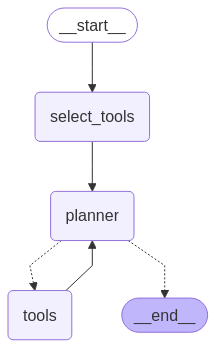

In [23]:
task_message = """
You are required to extract details from the bill provided and process the extracted text into an expense claim document.
In creating the document exclude items that are not reimbursable according to the company policy.
Note that service charge is 10% of the reimbursable amount, state GST is 2.5%, central GST is 2.5%, and VAT is 20%.
Use the above rates to compute the taxes and charges.
Present your final output in the following markdown format.
# Expense Claim Report

## Employee Name: <Insert Employee Name>
## Date: <Insert Date from original bill>
## Bill No: <Insert Bill No from original bill>
## Restaurant Name and Address: <Insert Restaurant Name and Address fromm original bill>
## Items ordered quantity and price (<arrange in a table format from verified list of items>):
    |Item|Quantity|Price|
        ...
    ...
### Tax and Charges: <enter the tax amount from calculated amounts>
### Total amount to be reimbursed: <enter the total from calculated amounts>
Do not output anything except the above details in your output.
Do not delimit the output with any extra tags (e.g., ```).
"""

In [24]:
result = agent_workflow.invoke(
    {
        "messages": [
            ("system", task_message),
            ("user", input_bill_path)
        ]
    },
    stream_mode="values"
)

In [25]:
result['query']

'restaurant-bill.jpg'

In [26]:
# Markdown(result['messages'][-1].content)
print(result['messages'][-1].content)

# Expense Claim Report

## Employee Name: <Insert Employee Name>
## Date: 29/10/19
## Bill No: R006429
## Restaurant Name and Address: Nukkad Café & Bar, C-23, 24 SDA Market New Delhi 110016
## Items ordered quantity and price:
    |Item           |Quantity|Price |
    |---------------|--------|------|
    |Masala Peanuts |1       |165.00|
    |Chicken 65     |1       |355.00|
### Tax and Charges: 182.0
### Total amount to be reimbursed: 702.0


In [27]:
for message in result['messages']:
    message.pretty_print()

================================ System Message ================================


You are required to extract details from the bill provided and process the extracted text into an expense claim document.
In creating the document exclude items that are not reimbursable according to the company policy.
Note that service charge is 10% of the reimbursable amount, state GST is 2.5%, central GST is 2.5%, and VAT is 20%.
Use the above rates to compute the taxes and charges.
Present your final output in the following markdown format.
# Expense Claim Report

## Employee Name: <Insert Employee Name>
## Date: <Insert Date from original bill>
## Bill No: <Insert Bill No from original bill>
## Restaurant Name and Address: <Insert Restaurant Name and Address fromm original bill>
## Items ordered quantity and price (<arrange in a table format from verified list of items>):
    |Item|Quantity|Price|
        ...
    ...
### Tax and Charges: <enter the tax amount from calculated amounts>
### Total amou